# Solving the Schroedinger Equations Using the Finite Difference Itme Domain Method

10.1088/1751-8113/40/8/013

In [1]:
import dataclasses
import math

import numpy as np

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from tqdm import tqdm

In [2]:
@dataclasses.dataclass(frozen=True)
class Boundary:
    start: float
    end: float
    step: float

In [3]:
class DirichletSystem:
    def __init__(self, pot, time_dom, spatial_doms, bd_cond=None, max_iter=None, stop_tol=1.0e-5, prior_vecs=None, **kwargs) -> None:
        self.pbc = False
        if prior_vecs is None:
            self.priors = []
        else:
            self.priors = list(prior_vecs)
        self.pot = pot
        # 0: time, 1: X, 2: Y, 3: Z
        self.time_dom = time_dom
        self.spat_dom = list(spatial_doms)
        self.vol = np.prod([dom.step for dom in self.spat_dom])
        self.time_len = int((time_dom.end - time_dom.start) / time_dom.step) + 1
        self._init_mesh()
        # self._initialize()
        self.bd_cond = bd_cond
        self.counter = 0
        self.stop_tol = stop_tol
        self.max_iter = max_iter
        self.logs = []
    
    def _init_mesh(self):
        self.spaces = [np.linspace(dom.start, dom.end, int((dom.end - dom.start) / dom.step) + 1) for dom in self.spat_dom]
        space_meshs = [x for x in np.meshgrid(*self.spaces, indexing='ij')]
        print(space_meshs[0].shape)
        self.sol_mesh = np.zeros([*space_meshs[0].shape])
        self.sol_shape = tuple(self.sol_mesh.shape)
        self.space_meshs = np.asarray([x.flatten() for x in space_meshs])
        self.ndim = len(self.sol_shape)

    def normalize(self, psi):
        nn = np.sqrt(np.sum(psi * psi) * self.vol)
        nn = 1.0 / nn
        out = psi * nn
        return out

    def _initialize(self, psi0_grid):
        self.sol_mesh = psi0_grid
        self._apply_boundary()

        pot_grid = np.zeros(np.prod(self.sol_shape))
        for i, xi in enumerate(zip(*self.space_meshs)):
            pot_grid[i] = self.pot(*xi)
        self.pot_grid = pot_grid.reshape(self.sol_shape)

#     def set_psi0_by_func(self, func):
#         psi0_grid = np.zeros(np.prod(self.sol_shape))
#         for i, xi in enumerate(zip(*self.space_meshs)):
#             psi0_grid[i] = func(*xi)
#         psi0_grid = psi0_grid.reshape(self.sol_shape)
#         self._initialize(psi0_grid)

    def set_psi0_by_grid(self, psi0_grid):
        self._initialize(psi0_grid)

    def _apply_boundary(self):
        if (self.bd_cond is None) and (self.pbc == False):
            sx = slice(None, None, None)
            for i, l in enumerate(self.sol_shape):
                ind = tuple([0 if i == j else sx for j in range(self.ndim)])
                self.sol_mesh[ind] = 0.0
                ind = tuple([l - 1 if i == j else sx for j in range(self.ndim)])
                self.sol_mesh[ind] = 0.0
                
    def _prepare(self, *args, **kwargs):
        psi = self.sol_mesh
        for vec in self.priors:
            inner = np.sum(psi * self.normalize(vec) * self.vol)
            self.sol_mesh -= inner * vec

    def solve(self):
        dt = self.time_dom.step
        self.energy_series = np.zeros(self.time_len)
        sx = slice(None, None, None)

        beta = 1.0 / (1.0 + 0.5 * dt * self.pot_grid)
        alpha = (1.0 - 0.5 * dt * self.pot_grid) * beta
        self._prepare()
        
        if self.max_iter is not None and self.max_iter < self.time_len:
            t_len = self.max_iter
        else:
            t_len = self.time_len
    
        kine = np.zeros(self.sol_shape)
        term = np.zeros(self.sol_shape)
        for n in tqdm(range(0, t_len)):
            self.counter = n
            kine.fill(0)
            px = self.sol_mesh

            self._prepare()
            
            for i in range(self.ndim):
                if self.pbc:
                    ind0 = tuple([0 if i == j else sx for j in range(self.ndim)])
                    ind1 = tuple([1 if i == j else sx for j in range(self.ndim)])
                    ind2 = tuple([-1 if i == j else sx for j in range(self.ndim)])
                    ind3 = tuple([-2 if i == j else sx for j in range(self.ndim)])
                    
                    px[ind2] = px[ind0] + (1/3) * px[ind3] - (1/3) * px[ind1]
                
                ind1 = tuple([slice(1, -1, None) if i == j else sx for j in range(self.ndim)])
                ind2 = tuple([slice(0, -2, None) if i == j else sx for j in range(self.ndim)])
                ind3 = tuple([slice(2, None, None) if i == j else sx for j in range(self.ndim)])

                term = px[ind2] + px[ind3] - 2.0 * px[ind1]

                if self.pbc:
                    ind0 = tuple([0 if i == j else sx for j in range(self.ndim)])
                    ind1 = tuple([1 if i == j else sx for j in range(self.ndim)])
                    ind2 = tuple([-1 if i == j else sx for j in range(self.ndim)])
                    ind3 = tuple([-2 if i == j else sx for j in range(self.ndim)])
                    
                    term += px[ind3]
                    term += px[ind1]
                    term -= px[ind0]
                    term -= px[ind2]
                
                ind1 = tuple([slice(1, -1, None) if i == j else sx for j in range(self.ndim)])
                term /= (2.0 * self.spat_dom[i].step ** 2)
                kine[ind1] += term

            energy_before = np.sum(self.pot_grid * px * px) - (kine * px).sum()
            energy_before /= (px * px).sum()

            self.energy_series[n] = energy_before # * self.vol ** 2
            
            if n + 1 < self.time_len:
                self.sol_mesh = alpha * self.sol_mesh
                self.sol_mesh += dt * beta * kine
                # self._apply_boundary(n + 1)
                
                psi = self.sol_mesh
                nn2 = np.sum(psi * psi) * self.vol
                self.logs.append(np.sqrt(nn2))
                
                self.sol_mesh = self.normalize(self.sol_mesh)

            if n > 0 and self.stop_tol is not None:
                error = np.abs(1 - self.energy_series[n - 1] / energy_before)
                if error < self.stop_tol:
                    break

    def get_solution(self):
        return self.spaces, self.sol_mesh
    
    def get_full_mesh(self):
        return self.spaces, self.sol_mesh

    def get_energy(self):
        return self.energy_series

In [10]:
def draw_energies(ex):
    fig1, ax1 = plt.subplots()
    y1 = np.ones_like(ex[0]) * (1+1+1)*np.pi**2 /2
    y2 = np.ones_like(ex[0]) * (1+1+4)*np.pi**2 /2
    y3 = np.ones_like(ex[0]) * (1+4+4)*np.pi**2 /2
    y4 = np.ones_like(ex[0]) * (4+4+4)*np.pi**2 /2
    ax1.plot(y1, label="$3\pi^{2}/2$")
    ax1.plot(y2, label="$6\pi^{2}/2$")
    ax1.plot(y3, label="$9\pi^{2}/2$")
    ax1.plot(y4, label="$12\pi^{2}/2$")
    for i,ee in enumerate(ex):
        ax1.plot(ee, label=f"{i+1}th Energy")
    ax1.grid()
    ax1.set_ylim(0, 150.0)
    fig1.legend()
    ax1.set_title("3d particle in a box")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Energy")
    fig1.savefig('3d-free.png', dpi=300)
    plt.show(fig1)

In [5]:
x0, x1, dx = 0.0, 1.0, 0.01
t0, t1, dt = 0.0, 1.0, dx*dx*0.2
ndim = 3
dom_t = Boundary(t0, t1, dt)
dom_x = Boundary(x0, x1, dx)
space_dom = [dom_x] * ndim

def pot(mesh,adfbioadfjboi, adfbadfboiadf):
    return np.zeros_like(mesh)
    # return mesh*mesh*100

def init1(x):
    return np.random.randn(1)

def init2(x):
    return np.random.rand() * 2 - 1

sys1 = DirichletSystem(pot=pot, time_dom=dom_t, spatial_doms=space_dom, stop_tol=None, max_iter=None)
psi0 = np.random.randn(*sys1.sol_shape)
sys1.set_psi0_by_grid(psi0)
# sys1.set_psi0_by_func(init1)
sys1.solve()

# draw_energies([sys1.get_energy()])
_, u = sys1.get_solution()
v1 = u.copy()

sys2 = DirichletSystem(pot=pot, time_dom=dom_t, spatial_doms=space_dom, prior_vecs=[v1], stop_tol=None, max_iter=None)
sys2.set_psi0_by_grid(psi0)
# sys2.set_psi0_by_func(init1)
sys2.solve()

# draw_energies([sys2.get_energy()])
_, u = sys2.get_solution()
v2 = u.copy()

sys3 = DirichletSystem(pot=pot, time_dom=dom_t, spatial_doms=space_dom, prior_vecs=[v1, v2], stop_tol=None, max_iter=None)
sys3.set_psi0_by_grid(psi0)
sys3.solve()

# draw_energies([sys3.get_energy()])
_, u = sys3.get_solution()
v3 = u.copy()

sys4 = DirichletSystem(pot=pot, time_dom=dom_t, spatial_doms=space_dom, prior_vecs=[v1, v2, v3], stop_tol=None, max_iter=None)
sys4.set_psi0_by_grid(psi0)
sys4.solve()

# draw_energies([sys4.get_energy()])
_, u = sys4.get_solution()
v4 = u.copy()

(101, 101, 101)


100%|█████████████████████████████████████| 50000/50000 [22:02<00:00, 37.82it/s]


(101, 101, 101)


100%|█████████████████████████████████████| 50000/50000 [24:56<00:00, 33.40it/s]


(101, 101, 101)


100%|█████████████████████████████████████| 50000/50000 [26:36<00:00, 31.32it/s]


(101, 101, 101)


100%|█████████████████████████████████████| 50000/50000 [18:06<00:00, 46.03it/s]


In [6]:
from mpl_toolkits.mplot3d import Axes3D

/home/skku/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/art3d.py:906: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/home/skku/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/art3d.py:908: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
/home/skku/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/art3d.py:910: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir[0] == '-':


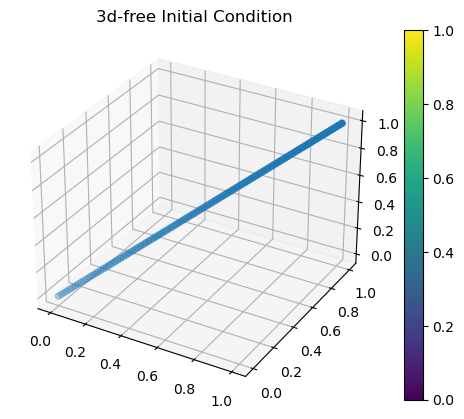

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
cntr = ax.scatter(sys2.spaces[0], sys2.spaces[1], sys1.spaces[2],psi0[1])
plt.colorbar(cntr)
# ax.contour3D(x, y, z, 20, cmap=plt.cm.rainbow)
ax.set_title("3d-free Initial Condition")
ax.grid()
plt.savefig('3d-free Initial Condition.png', dpi=300)
plt.show()

# gridx = np.linspace(0, 1, 1000)
# gridy = np.linspace(0, 1, 1000)
# gridz = np.linspace(0, 1, 1000)
# gridx, gridy, gridz = np.meshgrid(gridx, gridy, gridz)
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# z = lambda x, y, z: np.sqrt(8)*np.sin(np.pi*x)*np.sin(np.pi*y)*np.sin(np.pi*z)
# f = z(gridx, gridy, gridz)
# cntr = ax.contour3D(sys1.spaces[0], sys1.spaces[1],v1**2)
# cntr = ax.plot_surface(gridx, gridy, gridz, f**2, alpha=0.5, label="$4sin^{2}(np.pix)sin^{2}(np.piy)$")
# ax.set_title("3d-free Grounded state")
# # ax.legend()
# plt.colorbar(cntr)
# plt.savefig('3d-free Grounded state.png', dpi=300)

# plt.show()


In [8]:
print(3*np.pi**2/2)
sys1.get_energy()[-1]
print(4*np.pi**2/2)
sys2.get_energy()[1]

14.804406601634037
19.739208802178716


19186.703077388152

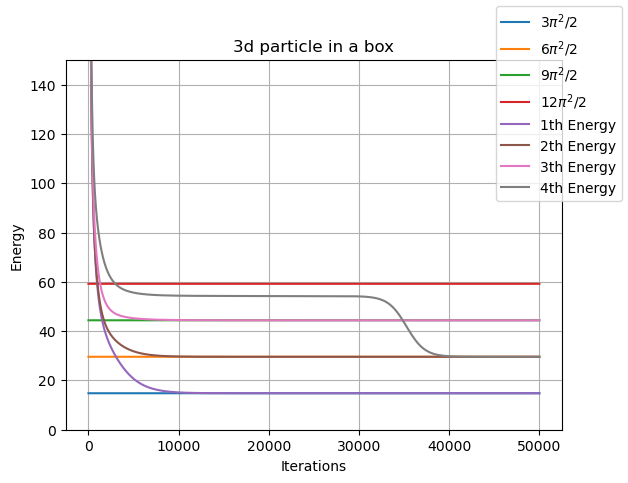

In [11]:
draw_energies([sys1.get_energy(),sys2.get_energy(),sys3.get_energy(),sys4.get_energy()])